## Imports

In [2]:
import os
import sunpy.map
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


##  Ruta a las IMG

In [3]:
# Ruta base a tus imágenes
base_dir = "/home/alyonaivanova/personal/SOLAR/Data/multichannel_SDO_AIA/"
# Definir los canales
channels = ["131.0Å", "171.0Å", "193.0Å", "211.0Å", "304.0Å", "335.0Å", "1600.0Å", "1700.0Å", "4500.0Å"]

### **Paso 1:  Crear Mosaico de Imágenes**
las longitudes de onda correspondientes a cada canal
- **131.0Å**: 10 million K (Flare Plasma)
- **171.0Å**: 1 million K (Quiet Corona)
- **193.0Å**: 1.25 million K (Active Corona)
- **211.0Å**: 2 million K (Hot Corona)
- **304.0Å**: 50,000 K (Chromosphere/Transition Region)
- **335.0Å**: 2.5 million K (Active Region Corona)
- **1600.0Å**: 6,000 K (Transition Region)
- **1700.0Å**: 5,000 K (Photosphere)
- **4500.0Å**: 6,000 K (Photosphere Continuum)


## Mascara

Observamos que los pixeles afuera del disco solar solo generaran ruido, entonces para
solucionar est voamos a implementar una máscara circular para eliminar los píxeles que no pertenecen
al disco solar. Usaremos la tabla de metadatos para determinar el radio del Sol en 
píxeles y crear la máscara.


### Pasos
1. **Calcular el radio del Sol en píxeles**:
   - Usamos el metadato `R_SUN` y la escala en píxeles (`CDELT1` o `CDELT2`).
2. **Crear la máscara circular**:
   - Usaremos la ecuación del círculo:
     \[
     (x - x_{\text{centro}})^2 + (y - y_{\text{centro}})^2 < R^2
     \]
3. **Aplicar la máscara**:
   - Establecemos los píxeles fuera del círculo como `NaN` o `0`.

In [4]:
def create_circular_mask(data, metadata):
    """
    Crea una máscara circular adaptada al disco solar en los datos.
    """
    ny, nx = data.shape
    x_center = nx // 2
    y_center = ny // 2
    
    # Determinar el radio del Sol en píxeles usando cdelt1 y cdelt2
    cdelt1 = metadata.get("cdelt1", 1.0)  # Arcsec/píxel en X
    solar_radius_arcsec = metadata.get("rsun_obs", 960.0)  # Radio solar en arcsec
    solar_radius_pixels = int(solar_radius_arcsec / cdelt1)

    # Crear las coordenadas de la malla
    y, x = np.ogrid[:ny, :nx]
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)

    # Crear la máscara
    mask = distance_from_center <= solar_radius_pixels
    return mask


In [5]:
channel_properties = {
    "131.0Å": {"cmap": "Blues", "description": "10 million K (Flare Plasma)"},
    "171.0Å": {"cmap": "YlGnBu", "description": "1 million K (Quiet Corona)"},
    "193.0Å": {"cmap": "Oranges", "description": "1.25 million K (Active Corona)"},
    "211.0Å": {"cmap": "Reds", "description": "2 million K (Hot Corona)"},
    "304.0Å": {"cmap": "PuRd", "description": "50,000 K (Chromosphere/Transition Region)"},
    "335.0Å": {"cmap": "Purples", "description": "2.5 million K (Active Region Corona)"},
    "1600.0Å": {"cmap": "pink", "description": "6,000 K (Transition Region)"},
    "1700.0Å": {"cmap": "Greys", "description": "5,000 K (Photosphere)"},
    "4500.0Å": {"cmap": "coolwarm", "description": "6,000 K (Photosphere Continuum)"}
}

channels = list(channel_properties.keys())

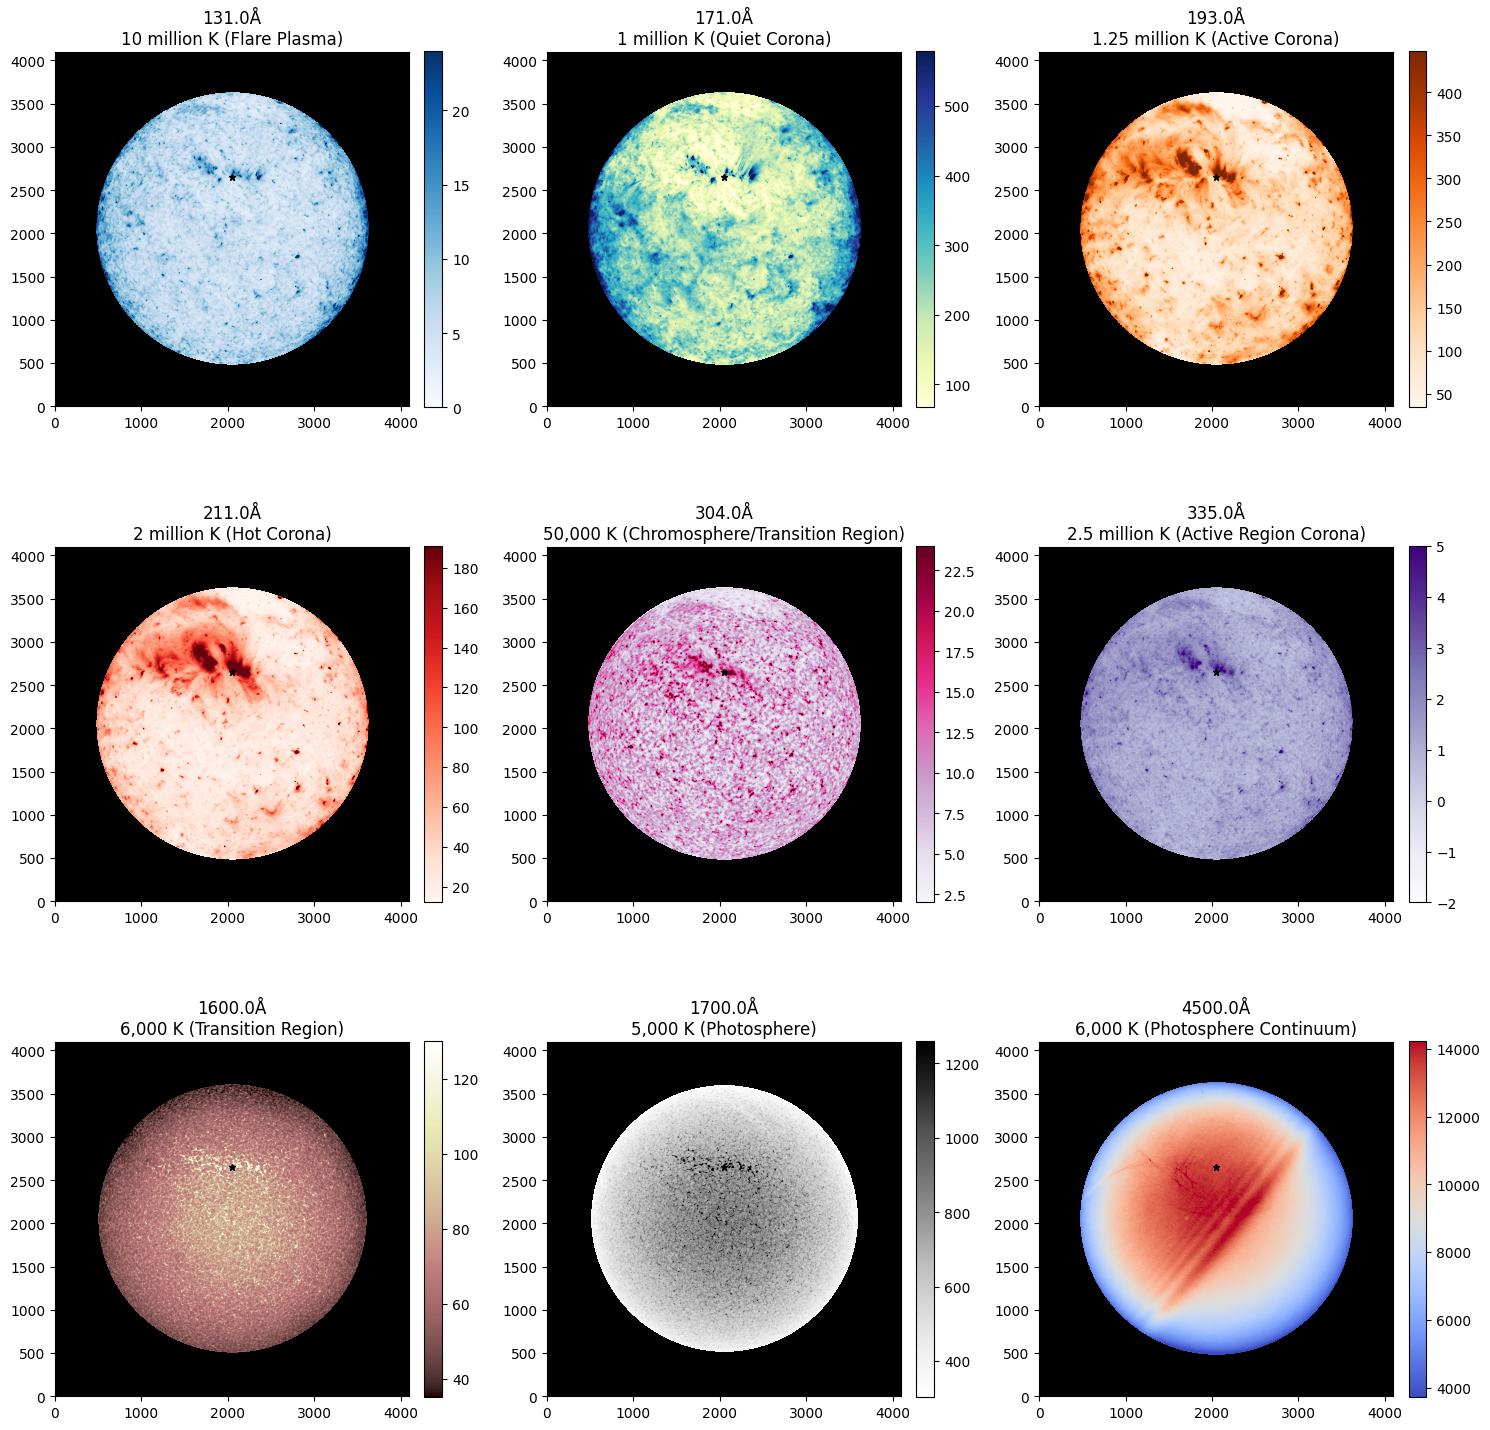

In [6]:
channel_data_process = {}

def process_and_plot_image_with_mask(channel, ax):
    channel_dir = os.path.join(base_dir, channel)
    fits_files = [f for f in os.listdir(channel_dir) if f.endswith(".fits")]
    
    if fits_files:  # Verificar si hay archivos FITS
        fits_path = os.path.join(channel_dir, fits_files[0])
        aia_map = sunpy.map.Map(fits_path)
        data = aia_map.data  # Obtener el arreglo numpy 2D
        
        # Crear máscara circular
        mask = create_circular_mask(data, aia_map.meta)
        masked_data = data.copy()  # Copiar los datos originales
        masked_data[~mask] = np.nan  # Aplicar la máscara: fuera del círculo -> NaN
        
        
        # Guardar los datos aplanados para scatter plots
        channel_data_process[channel] = masked_data.flatten()
        
        # Establecer límites de visualización (vmin, vmax)
        vmin = np.nanpercentile(masked_data, 1)  # 1er percentil (ignorando NaN)
        vmax = np.nanpercentile(masked_data, 99)  # 99º percentil (ignorando NaN)
        
        # Configurar el fondo negro para el eje
        ax.set_facecolor("black")
        
        # Mostrar la imagen en el eje
        props = channel_properties.get(channel, {"cmap": "gray", "description": "Unknown"})
        im = ax.imshow(masked_data, origin='lower', cmap=props["cmap"], vmin=vmin, vmax=vmax)
        ax.plot(2050,2650,"*k", ms=5)
        ax.set_title(f"{channel}\n{props['description']}", color="black")
        fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    else:
        ax.set_title(f"{channel} (No Data)", color="white")
        ax.axis("off")

# Crear la figura y los ejes para el mosaico
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Cambiar el fondo de la figura a negro
fig.patch.set_facecolor("white")

# Procesar cada canal individualmente con la máscara
for i, channel in enumerate(channels):
    process_and_plot_image_with_mask(channel, axes[i])

# Ajustar diseño
plt.tight_layout()
plt.show()


### **Paso 2: Crear la tabla de parámetros clave extraidos de los metaDatos**
Los parámetros clave que extraeremos para cada filtro son:
- **CDELT1**: Tamaño del píxel en dirección X.
- **CDELT2**: Tamaño del píxel en dirección Y.
- **CROTA2**: Rotación.
- **NAXIS1** y **NAXIS2**: Tamaño de la imagen.

In [7]:
table_data_process = []

# Función para procesar y extraer datos de la tabla
def extract_table_data(channel):
    channel_dir = os.path.join(base_dir, channel)
    fits_files = [f for f in os.listdir(channel_dir) if f.endswith(".fits")]
    
    if fits_files:  # Verificar si hay archivos FITS
        fits_path = os.path.join(channel_dir, fits_files[0])
        aia_map = sunpy.map.Map(fits_path)
        
        # Extraer metadatos clave
        metadata = aia_map.meta
        cdelt1 = metadata.get("cdelt1", "N/A")
        cdelt2 = metadata.get("cdelt2", "N/A")
        crota2 = metadata.get("crota2", "N/A")
        naxis1 = metadata.get("naxis1", "N/A")
        naxis2 = metadata.get("naxis2", "N/A")
        
        # Añadir metadatos a la tabla
        table_data_process.append({
            "Channel": channel,
            "CDELT1": cdelt1,
            "CDELT2": cdelt2,
            "CROTA2": crota2,
            "NAXIS1": naxis1,
            "NAXIS2": naxis2
        })

# Procesar cada canal individualmente
for channel in channels:
    extract_table_data(channel)
    
df = pd.DataFrame(table_data_process)
print(df)

   Channel    CDELT1    CDELT2    CROTA2  NAXIS1  NAXIS2
0   131.0Å  0.600698  0.600698 -0.138902    4096    4096
1   171.0Å  0.599489  0.599489  0.019441    4096    4096
2   193.0Å  0.600714  0.600714  0.057708    4096    4096
3   211.0Å  0.600758  0.600758  0.056357    4096    4096
4   304.0Å  0.600165  0.600165 -0.131746    4096    4096
5   335.0Å  0.600737  0.600737 -0.142371    4096    4096
6  1600.0Å  0.609373  0.609373  0.019860    4096    4096
7  1700.0Å  0.612898  0.612898  0.020444    4096    4096
8  4500.0Å  0.599945  0.599945  0.020710    4096    4096


## Generar scatter plots entre canales 
1. Sacamos el long de los datos.
2. Normalizamos los datos.

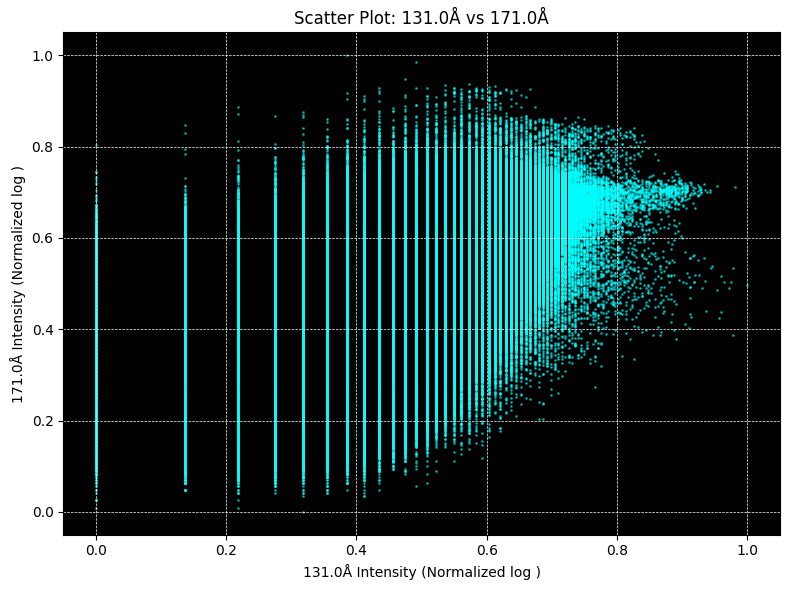

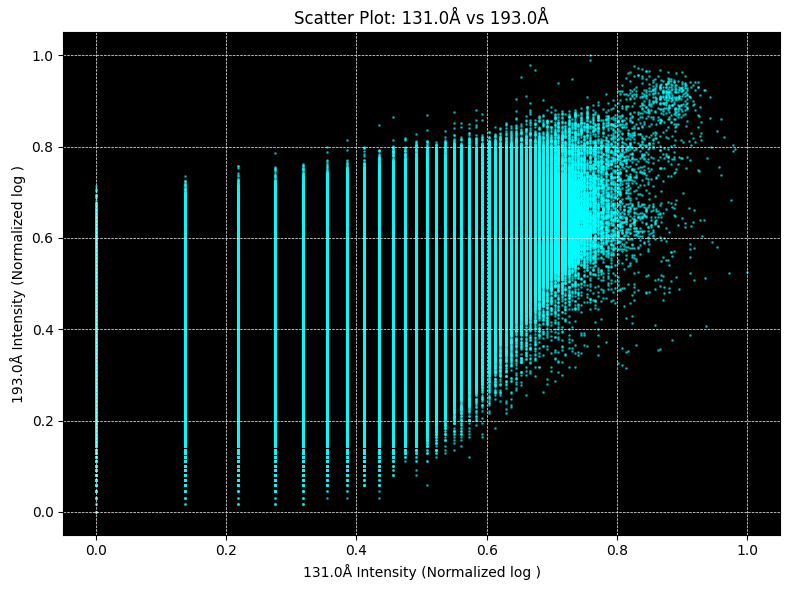

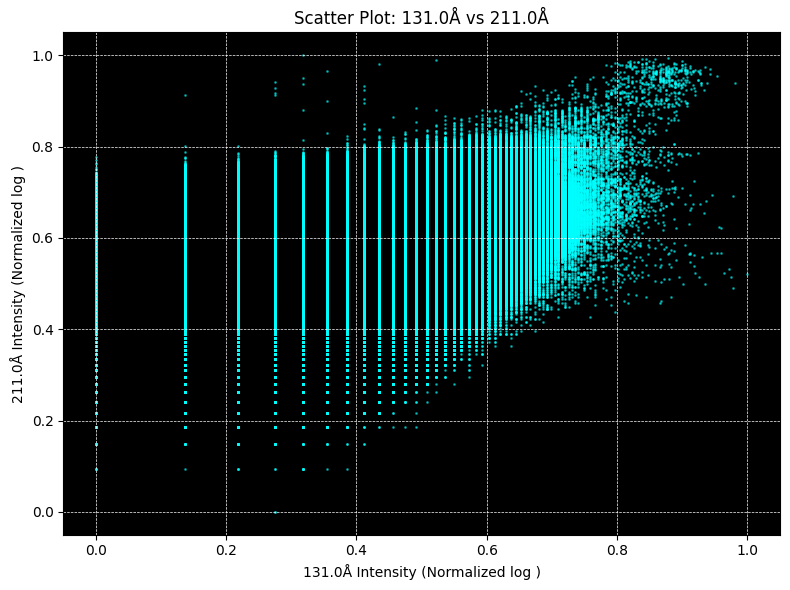

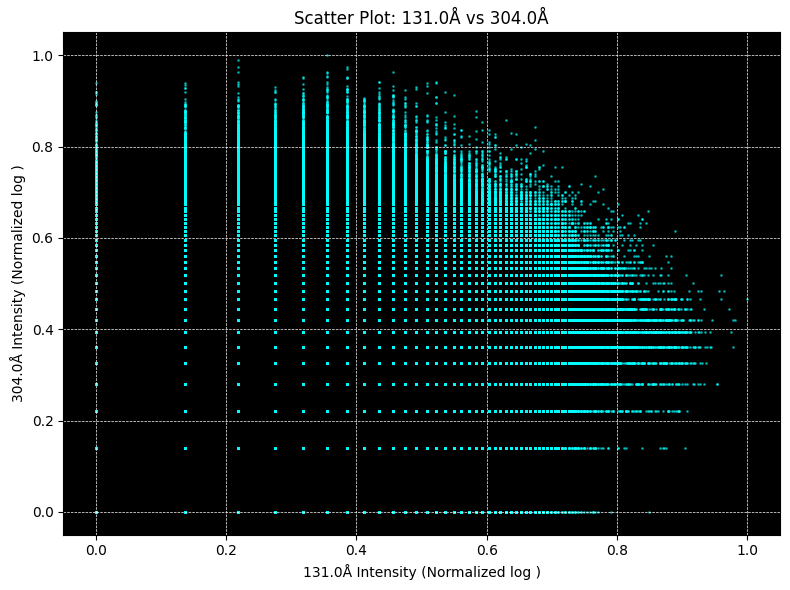

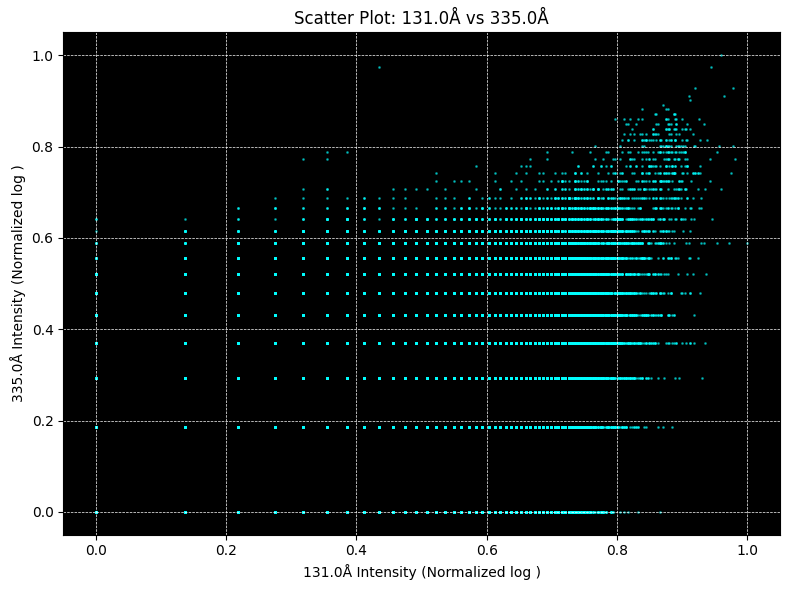

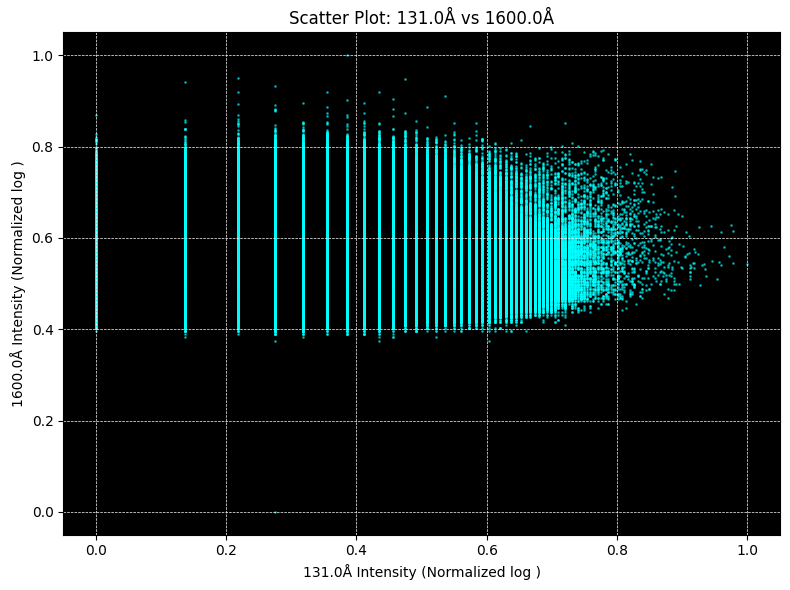

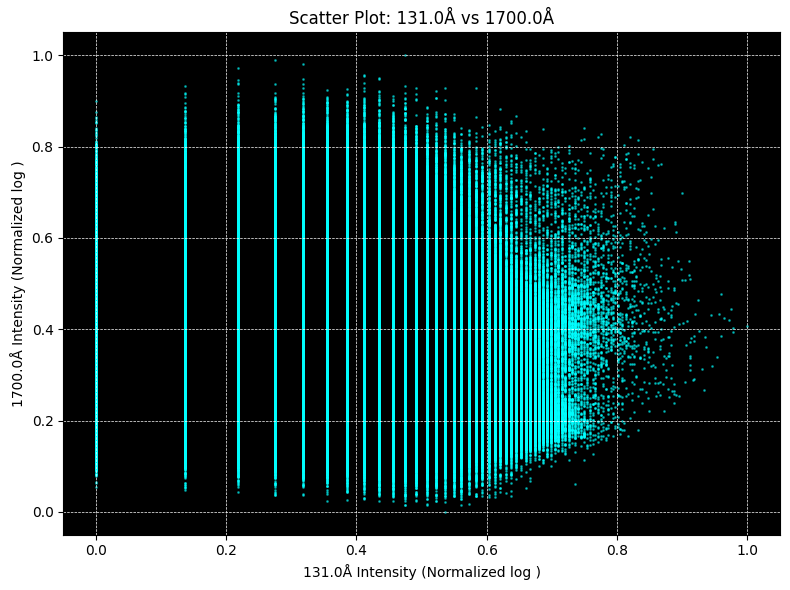

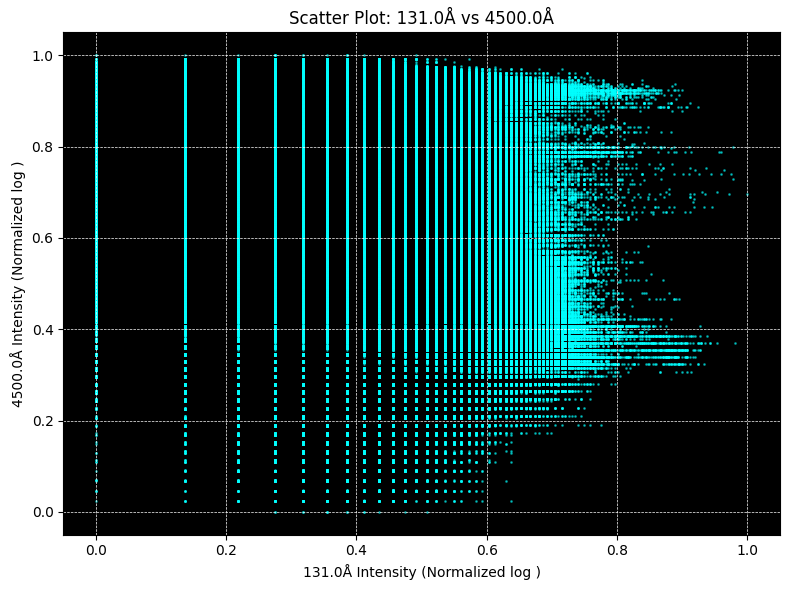

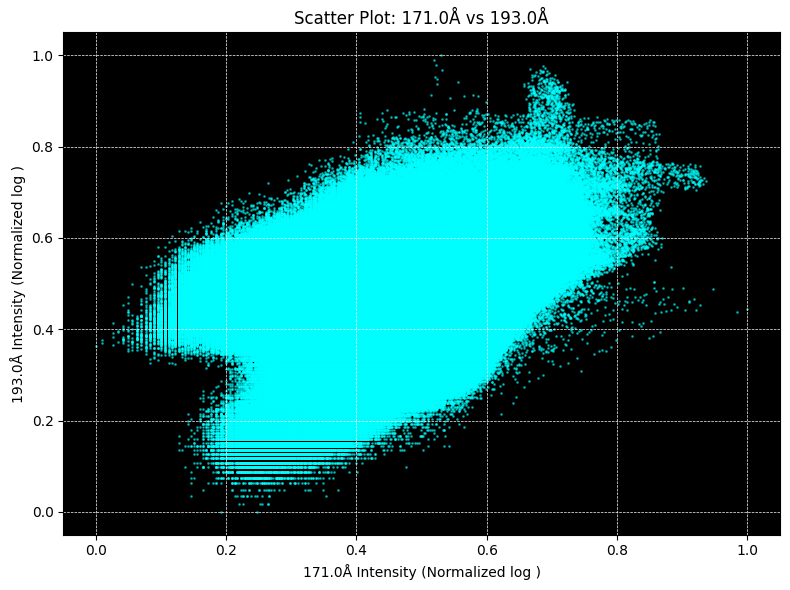

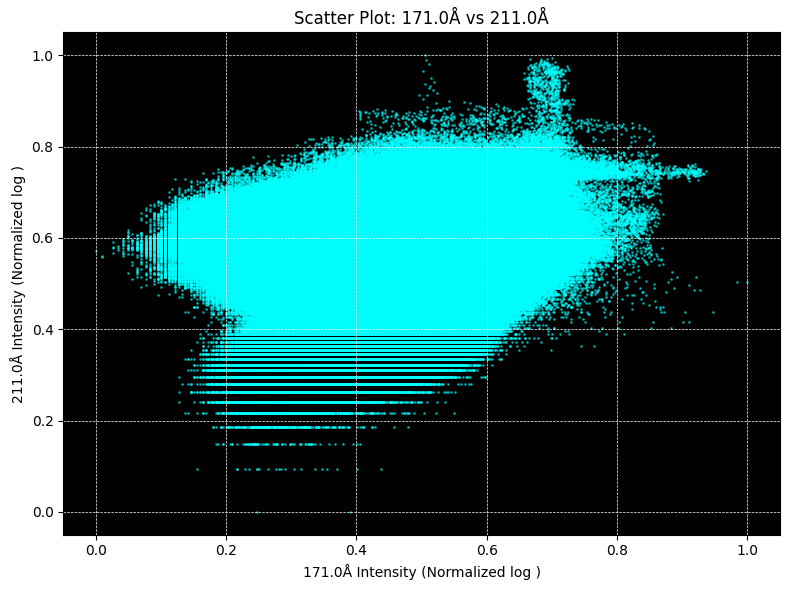

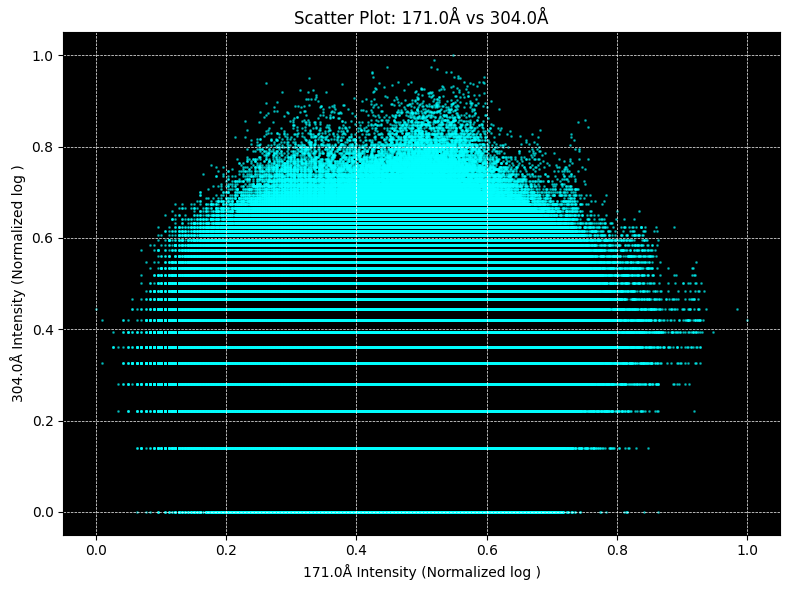

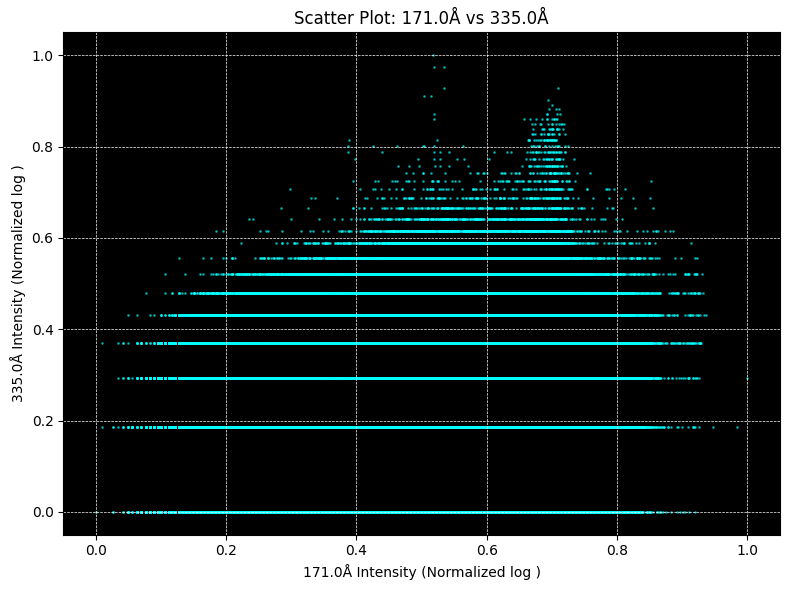

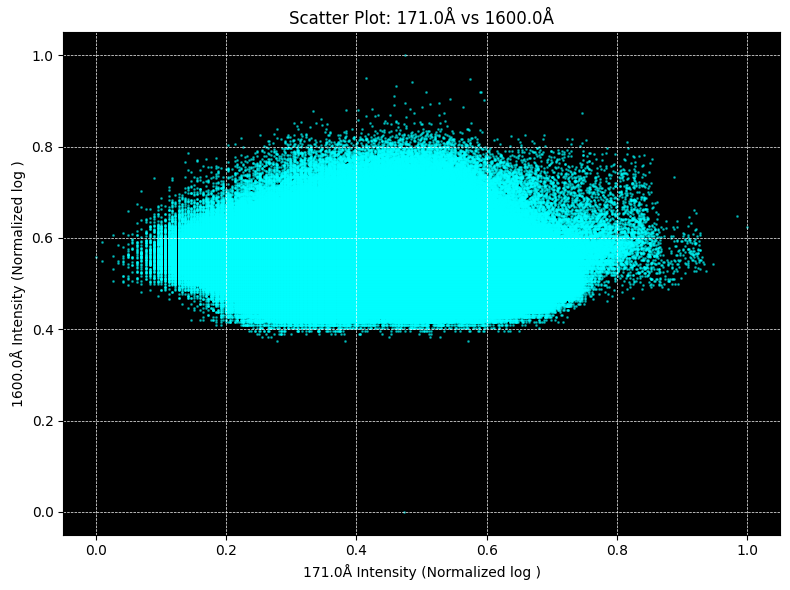

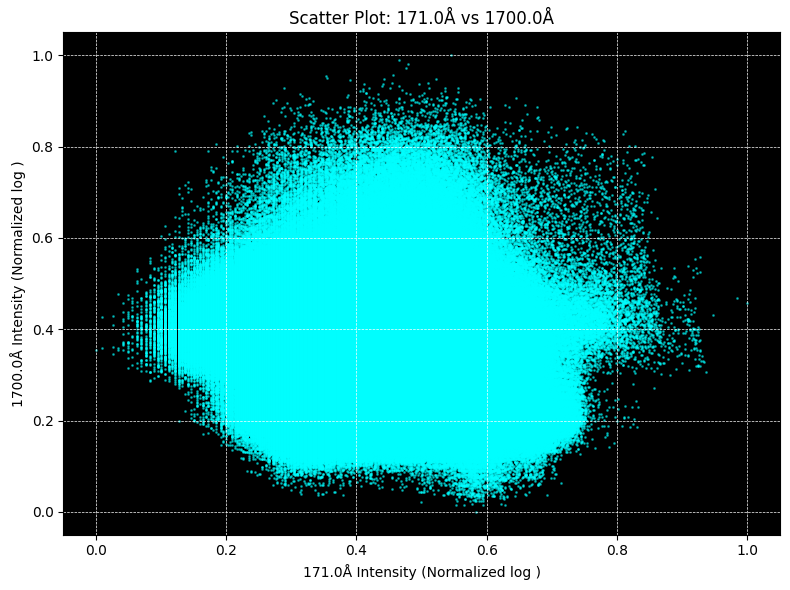

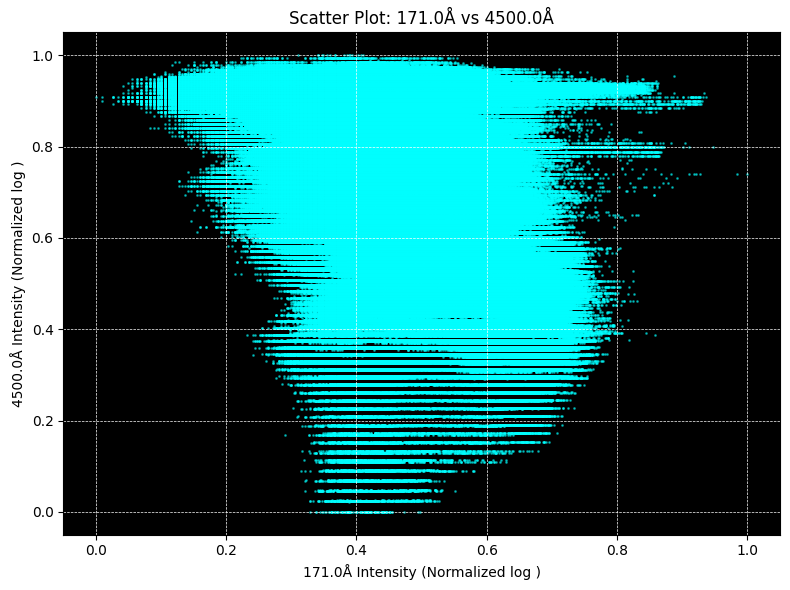

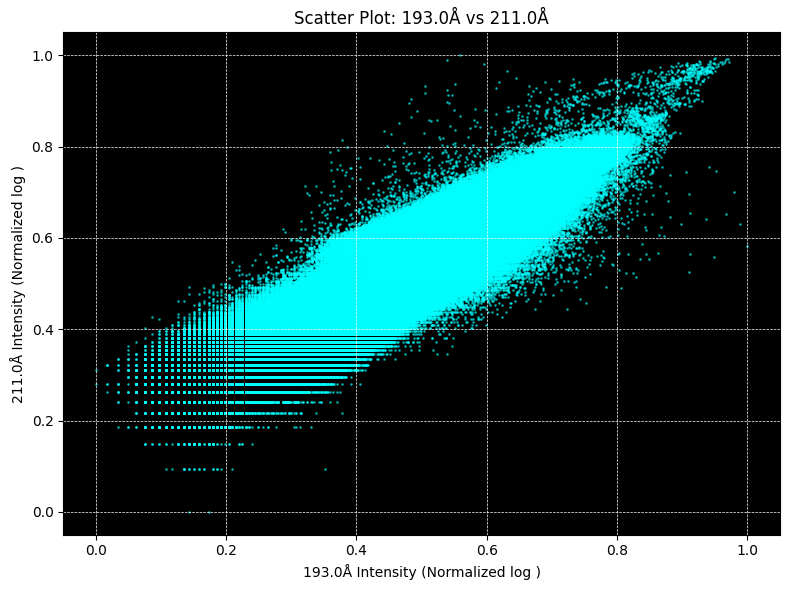

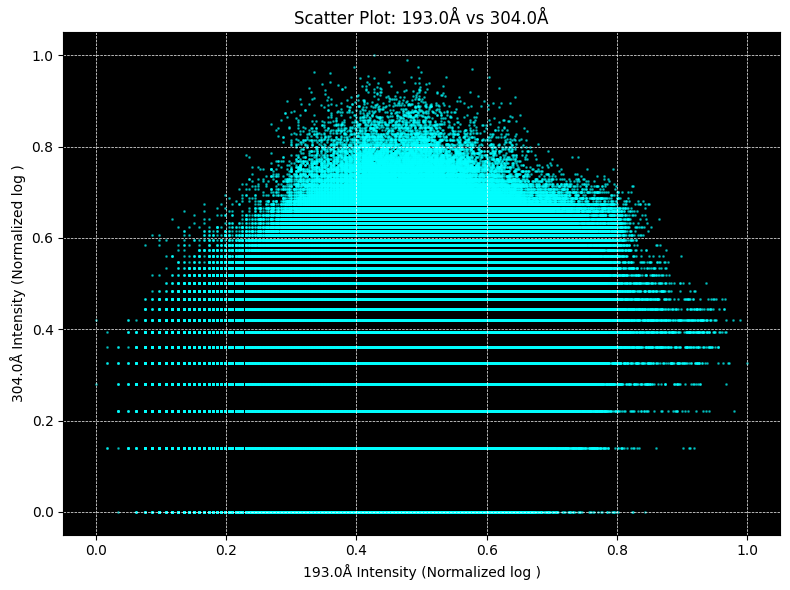

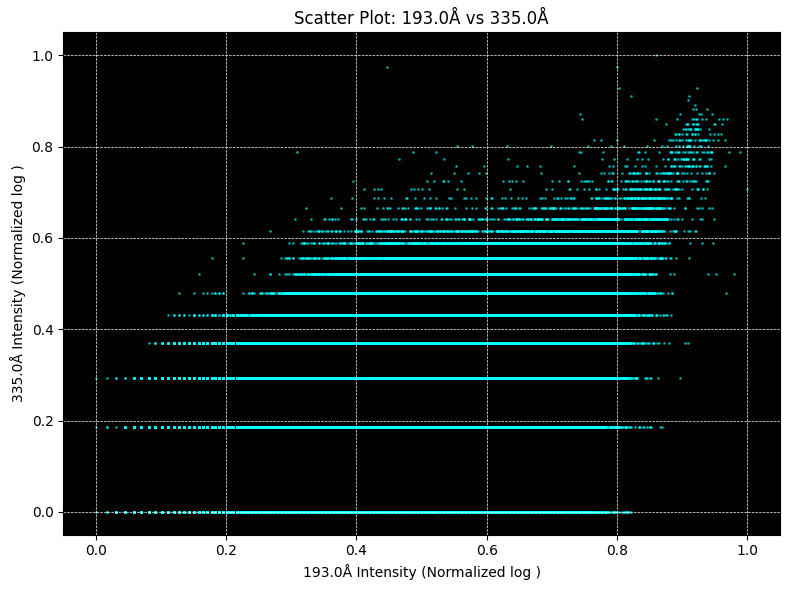

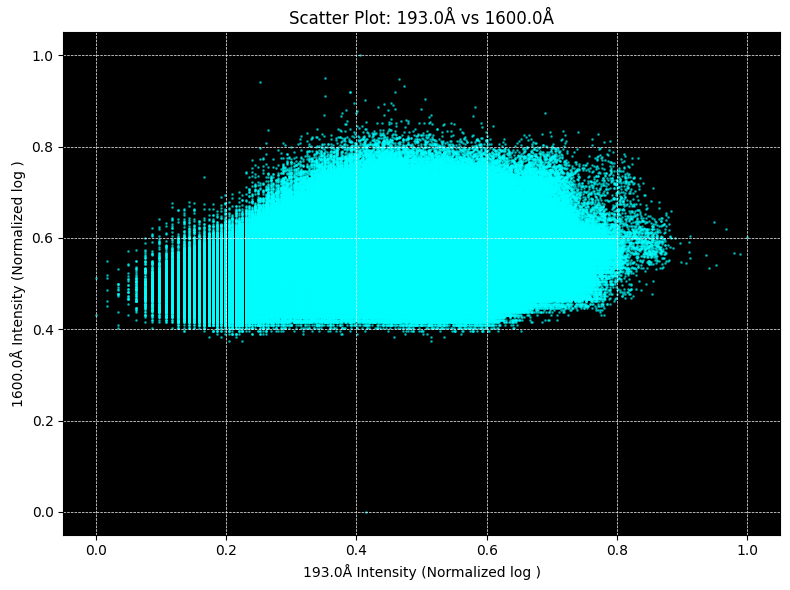

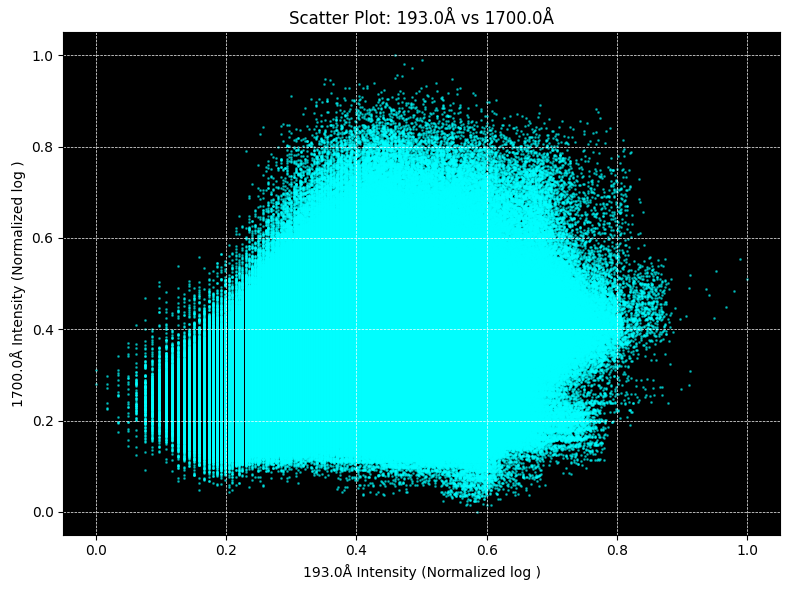

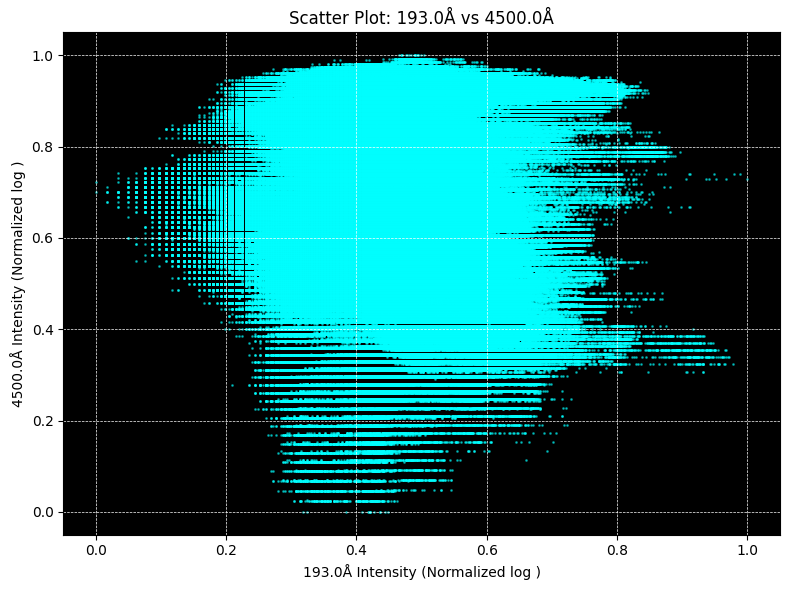

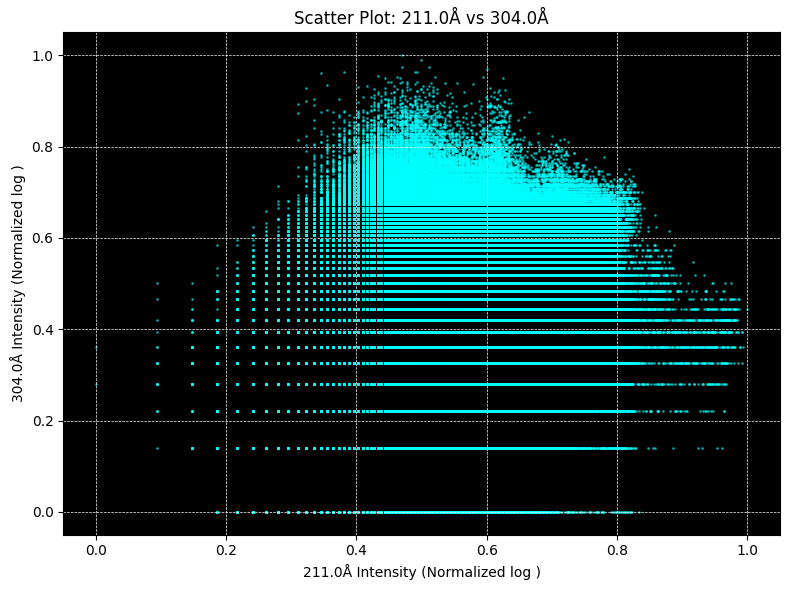

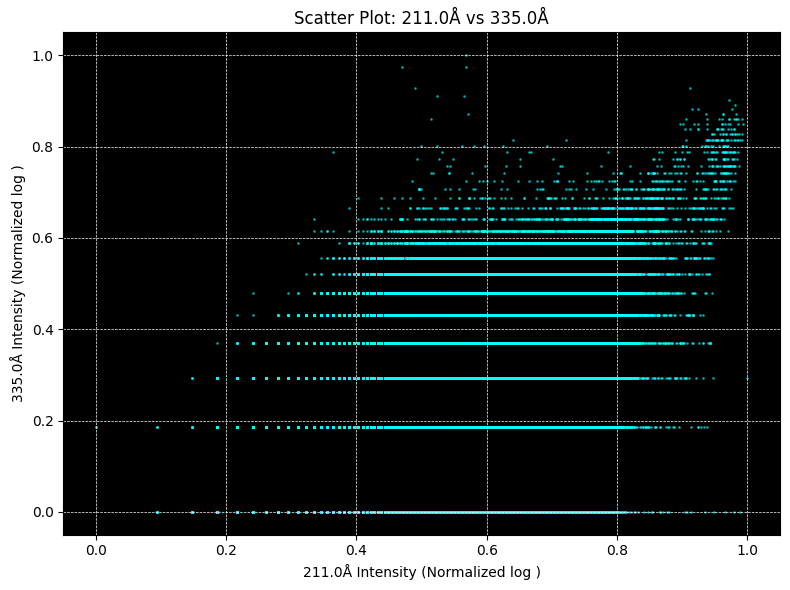

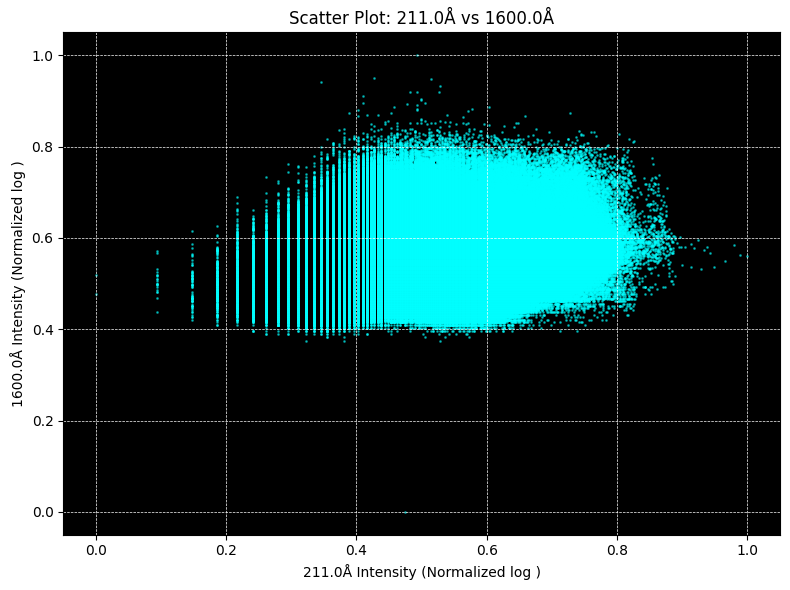

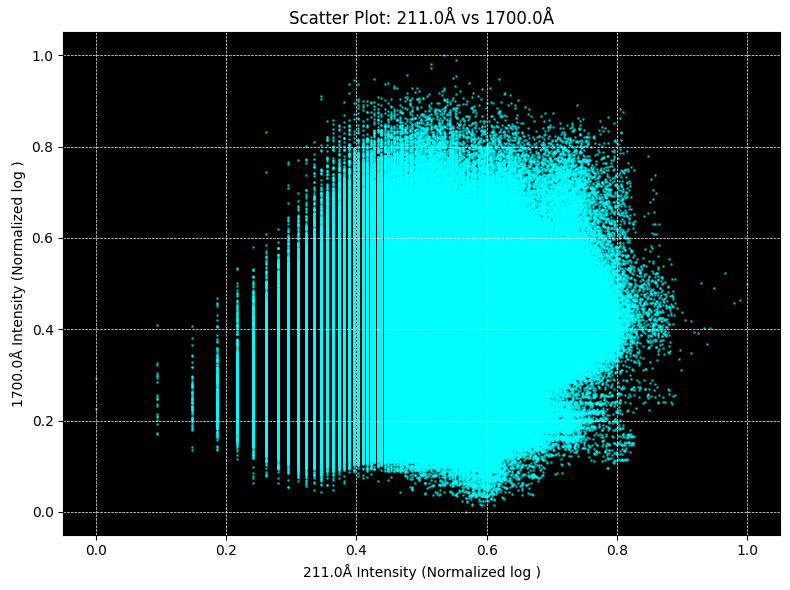

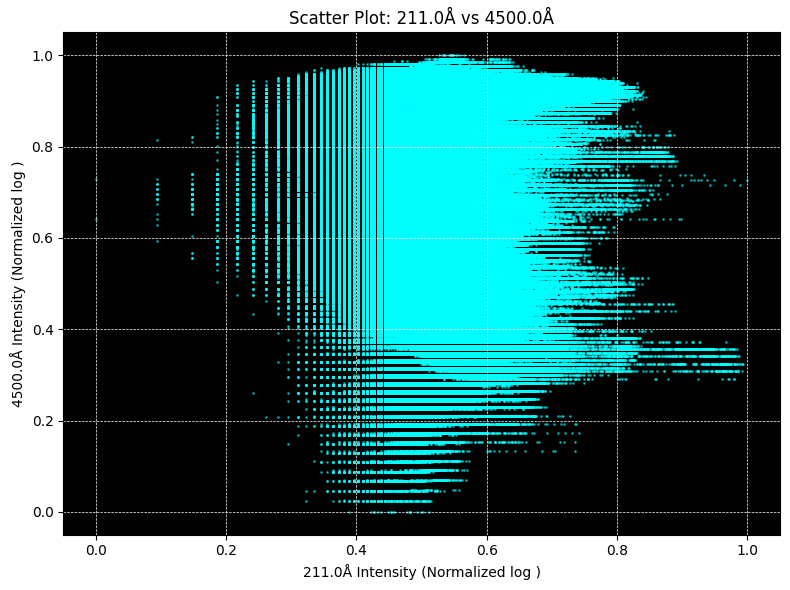

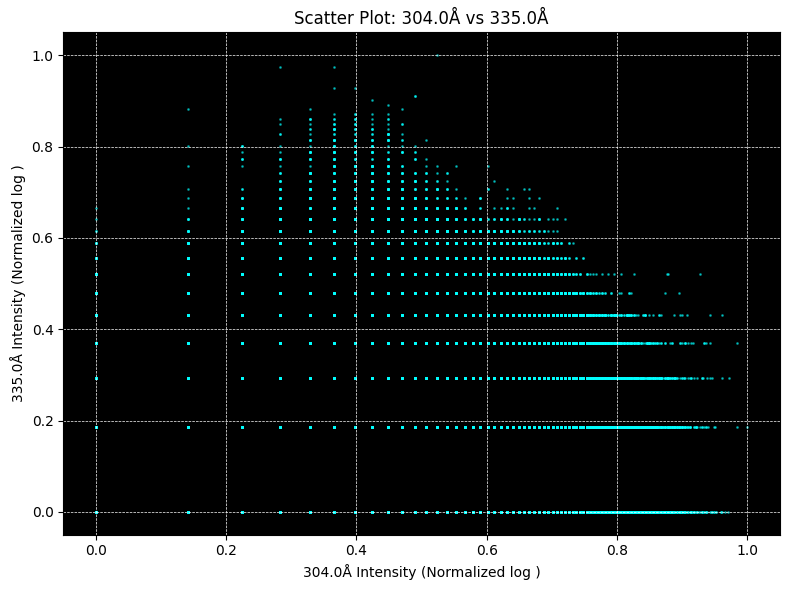

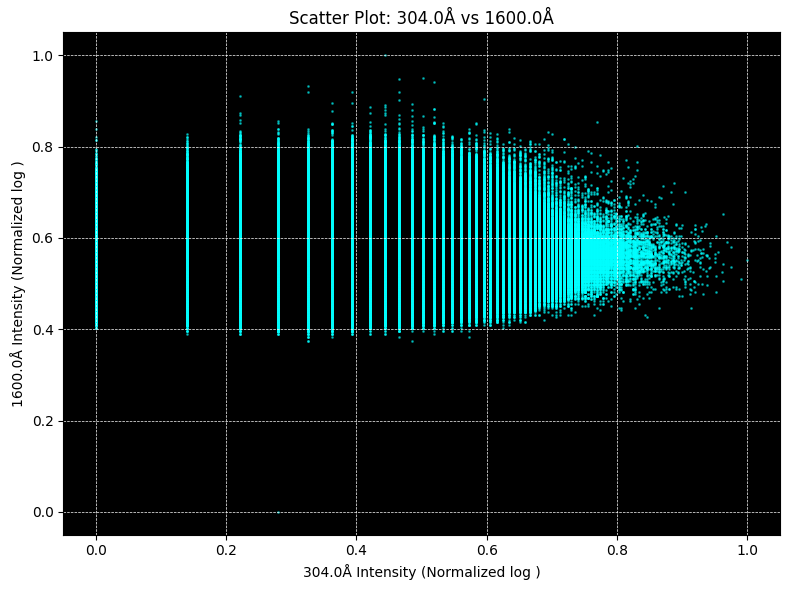

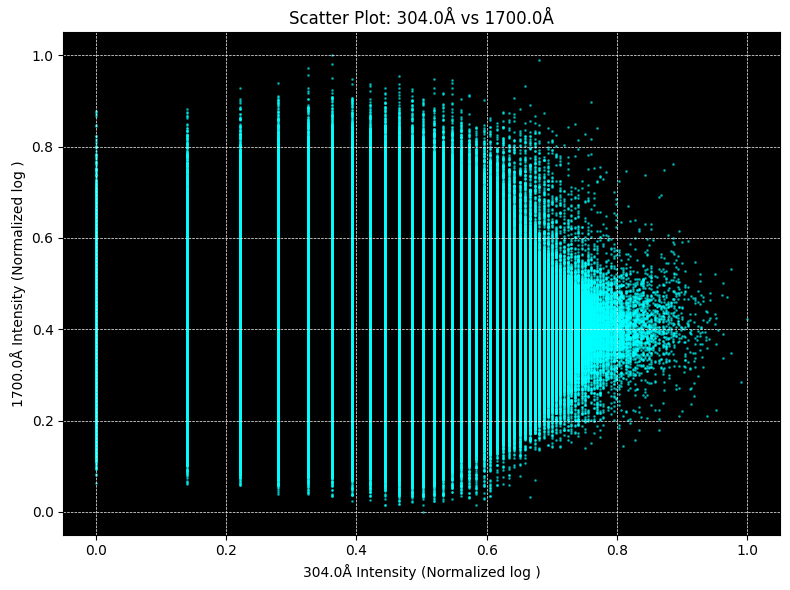

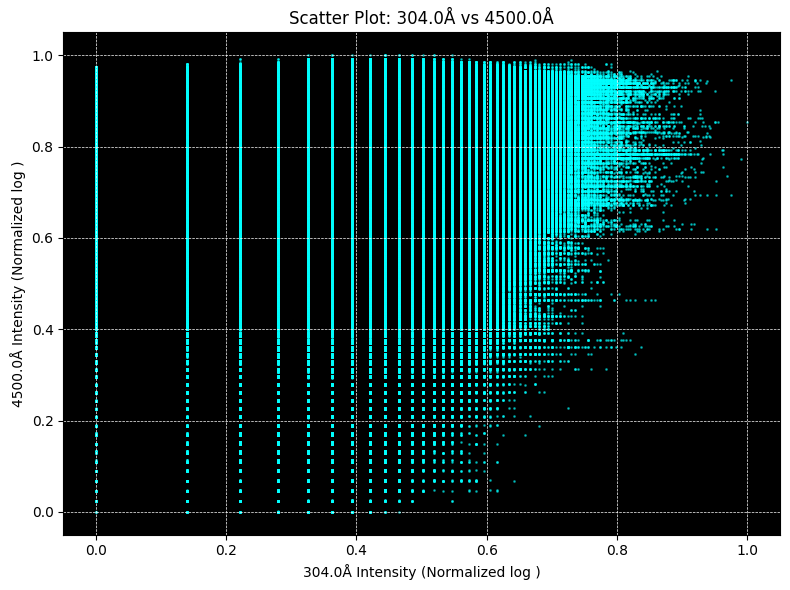

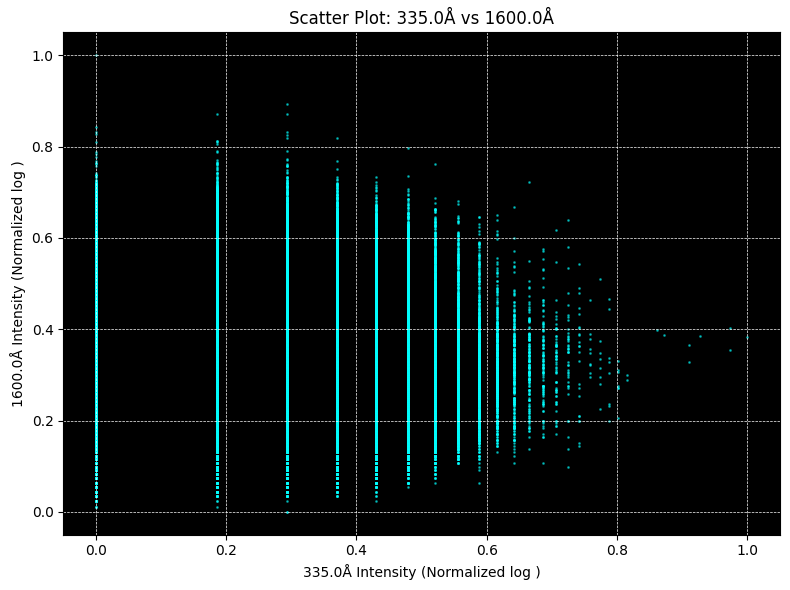

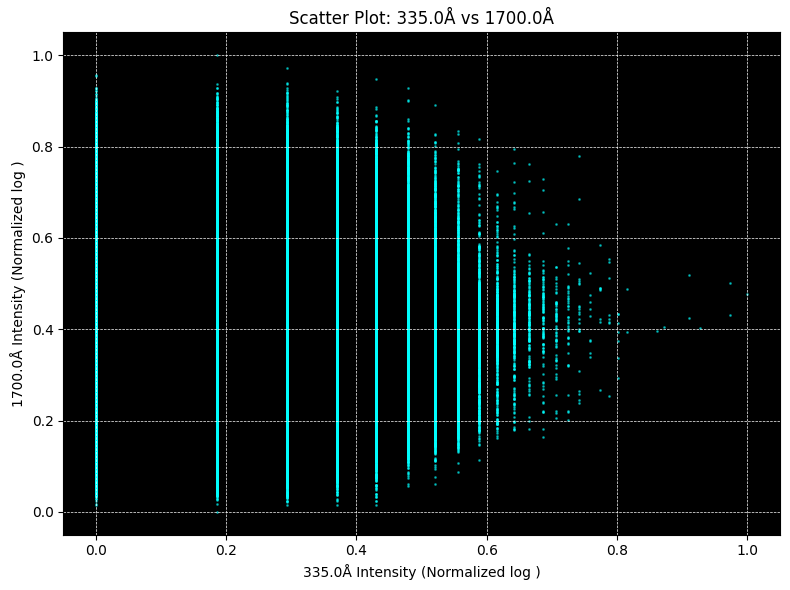

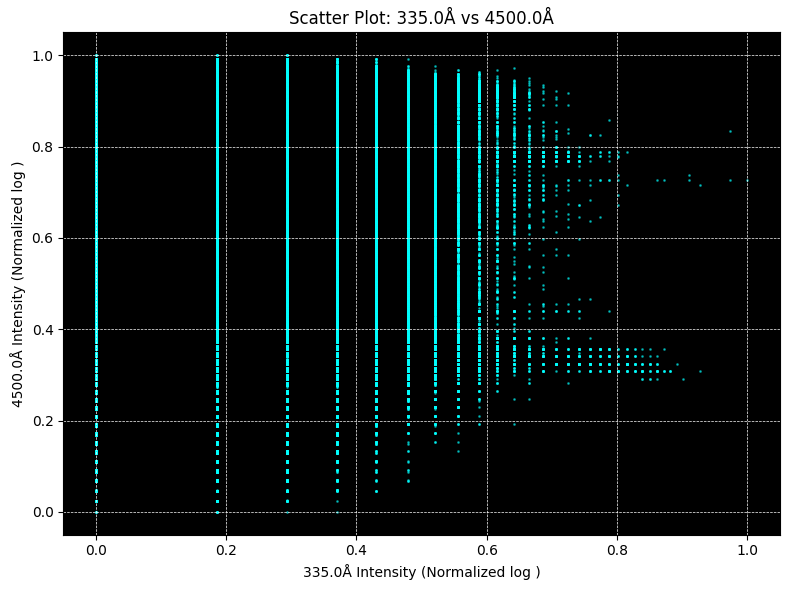

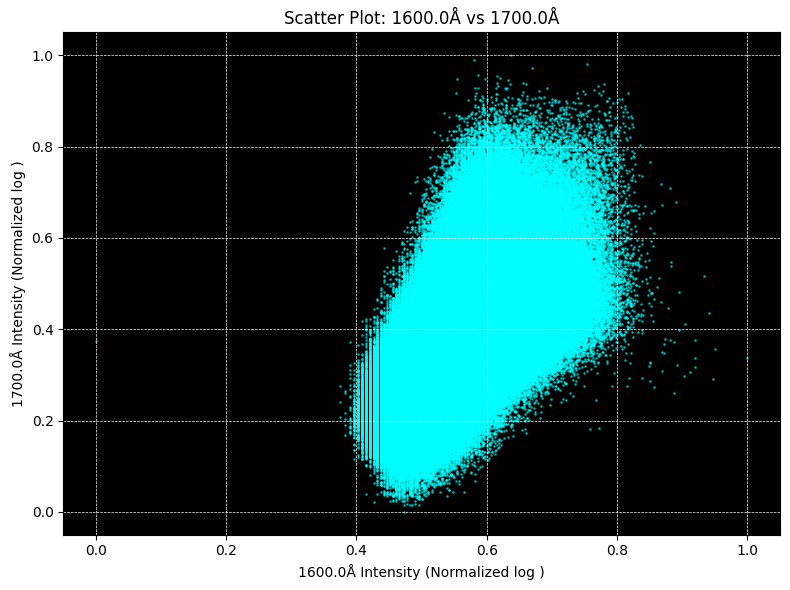

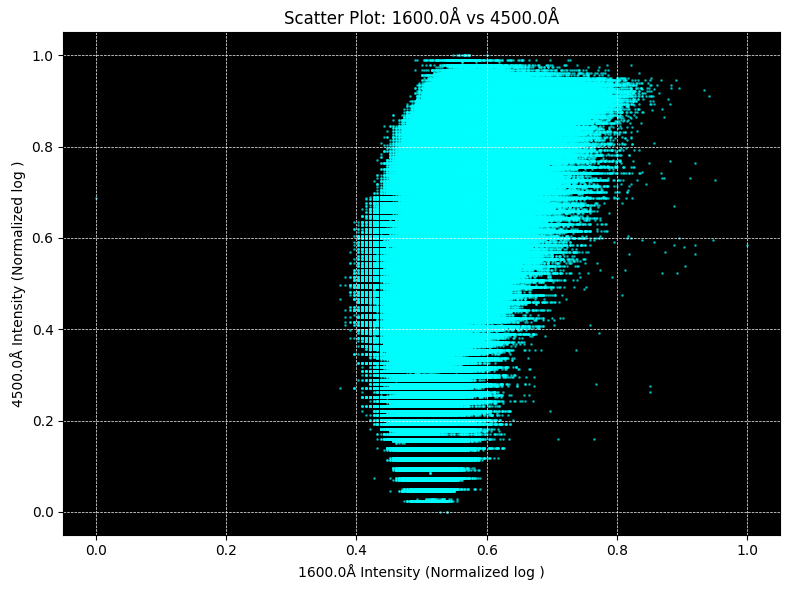

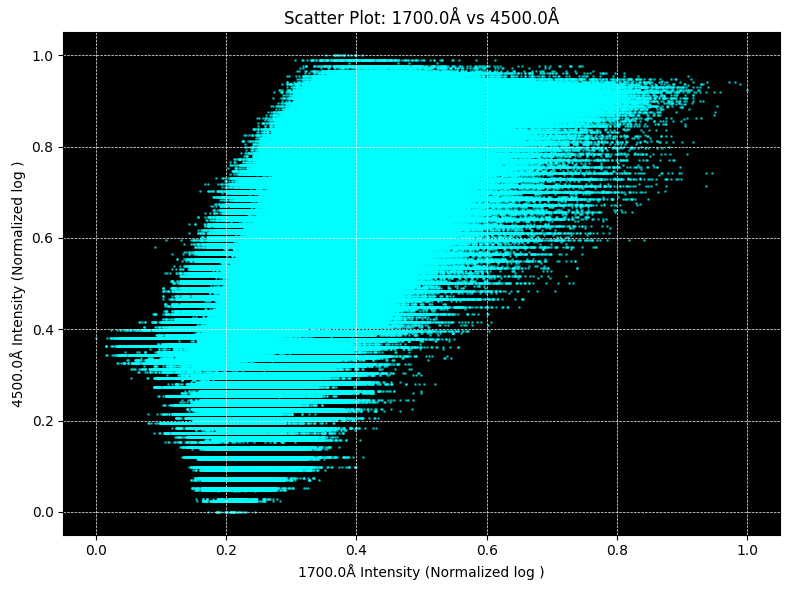

In [8]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Crear combinaciones de canales
combinations = [(c1, c2) for i, c1 in enumerate(channels) for c2 in channels[i + 1:]]

# Inicializar el escalador para normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))

for c1, c2 in combinations:
    if c1 in channel_data_process and c2 in channel_data_process:
        data1 = channel_data_process[c1]
        data2 = channel_data_process[c2]

        # Filtrar valores válidos (positivos y no NaN)
        valid_mask = (~np.isnan(data1)) & (~np.isnan(data2)) & (data1 > 0) & (data2 > 0)
        data1 = data1[valid_mask]
        data2 = data2[valid_mask]

        if len(data1) == 0 or len(data2) == 0:
            print(f"Sin datos válidos para los canales {c1} y {c2}.")
            continue

        # Calcular el logaritmo y normalizar
        log_data1 = np.log10(data1)
        log_data2 = np.log10(data2)
        normalized_data = scaler.fit_transform(np.column_stack((log_data1, log_data2)))
        norm_data1, norm_data2 = normalized_data[:, 0], normalized_data[:, 1]

        # Scatter plot
        plt.figure(figsize=(8, 6), facecolor="white")  # Fondo negro para la figura
        plt.gca().set_facecolor('black')  # Fondo negro para los ejes
        plt.scatter(norm_data1, norm_data2, s=1, alpha=0.5, c="cyan")
        plt.title(f"Scatter Plot: {c1} vs {c2}", color="black")  # Título en blanco
        plt.xlabel(f"{c1} Intensity (Normalized log )", color="black")  # Etiqueta X en blanco con aclaración
        plt.ylabel(f"{c2} Intensity (Normalized log )", color="black")  # Etiqueta Y en blanco con aclaración
        plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="white")
        plt.tight_layout()
        plt.show()


In [9]:
def process_channel(channel_data, channel_name):
    """
    Procesa los datos de un canal calculando el logaritmo y normalizando.
    
    Args:
        channel_data (dict): Diccionario con los datos de cada canal.
        channel_name (str): Nombre del canal a procesar.
    
    Returns:
        np.array: Datos normalizados y logarítmicos del canal.
    """
    # Verificar si el canal existe en los datos
    if channel_name not in channel_data:
        raise ValueError(f"El canal {channel_name} no está en los datos.")
    
    # Obtener los datos del canal
    data = channel_data[channel_name]
    
    # Filtrar valores válidos (positivos y no NaN)
    valid_mask = (~np.isnan(data)) & (data > 0)
    data = data[valid_mask]
    
    if len(data) == 0:
        raise ValueError(f"El canal {channel_name} no tiene datos válidos después del filtrado.")
    
    # Calcular el logaritmo
    log_data = np.log10(data)
    
    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()
    
    return normalized_data


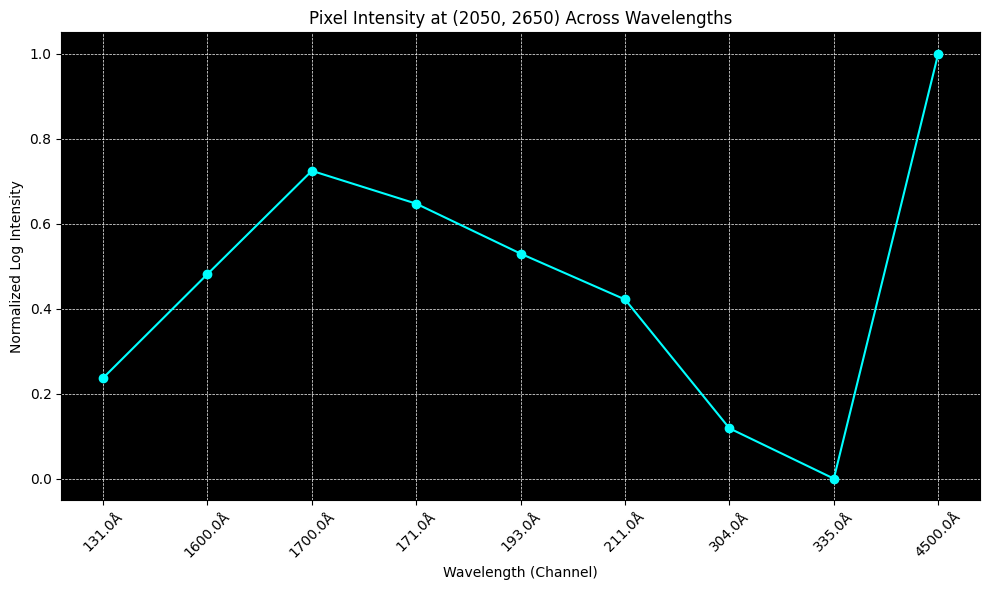

In [10]:
# Coordenadas del píxel que deseas analizar
pixel_x, pixel_y = 2050, 2650  # Cambia esto según las coordenadas que desees

# Inicializar un diccionario para almacenar los valores del píxel procesados
pixel_values = {}

# Iterar sobre los canales para extraer y procesar el valor del píxel en cada longitud de onda
for channel in channels:
    if channel in channel_data_process:
        # Obtener los datos correspondientes al canal
        data = channel_data_process[channel].reshape(4096, 4096)  # Ajustar tamaño si es necesario
        
        # Verificar si las coordenadas están dentro de los límites
        if 0 <= pixel_x < data.shape[0] and 0 <= pixel_y < data.shape[1]:
            pixel_value = data[pixel_x, pixel_y]
            
            # Procesar el valor del píxel (log y normalización)
            if not np.isnan(pixel_value) and pixel_value > 0:
                pixel_values[channel] = np.log10(pixel_value)  # Aplicar logaritmo
            else:
                pixel_values[channel] = np.nan  # Asignar NaN si el valor no es válido
        else:
            pixel_values[channel] = np.nan  # Asignar NaN si las coordenadas están fuera de los límites

# Normalizar los valores procesados
channels_sorted = sorted(pixel_values.keys())  # Ordenar las longitudes de onda para la gráfica
values_sorted = [pixel_values[ch] for ch in channels_sorted]

# Filtrar valores válidos para la normalización
valid_indices = [i for i, v in enumerate(values_sorted) if not np.isnan(v)]
values_filtered = np.array([values_sorted[i] for i in valid_indices]).reshape(-1, 1)

# Normalizar usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_values = scaler.fit_transform(values_filtered)

# Reconstruir el arreglo con NaN donde los valores eran inválidos
final_values = [np.nan] * len(values_sorted)
for i, idx in enumerate(valid_indices):
    final_values[idx] = normalized_values[i, 0]

# Visualizar los valores del píxel en las diferentes longitudes de onda
plt.figure(figsize=(10, 6), facecolor="white")
plt.plot(channels_sorted, final_values, marker='o', color='cyan')
plt.title(f"Pixel Intensity at ({pixel_x}, {pixel_y}) Across Wavelengths", color="black")
plt.xlabel("Wavelength (Channel)", color="black")
plt.ylabel("Normalized Log Intensity", color="black")
plt.xticks(rotation=45, color="black")
plt.yticks(color="black")
plt.grid(True, linestyle="--", linewidth=0.5, color="white")
plt.gca().set_facecolor("black")  # Fondo negro para los ejes
plt.tight_layout()
plt.show()


# Orden desde la superficie solar hacia afuera:
- 4500.0Å - Continuo de la fotosfera (Fotosfera).
- 1700.0Å - Fotosfera.
- 1600.0Å - Región de transición inferior.
- 304.0Å - Cromosfera/Región de transición.
- 171.0Å - Corona tranquila.
- 193.0Å - Corona activa.
- 211.0Å - Corona caliente.
- 335.0Å - Regiones activas de la corona.
- 131.0Å - Plasma de flare (Corona).

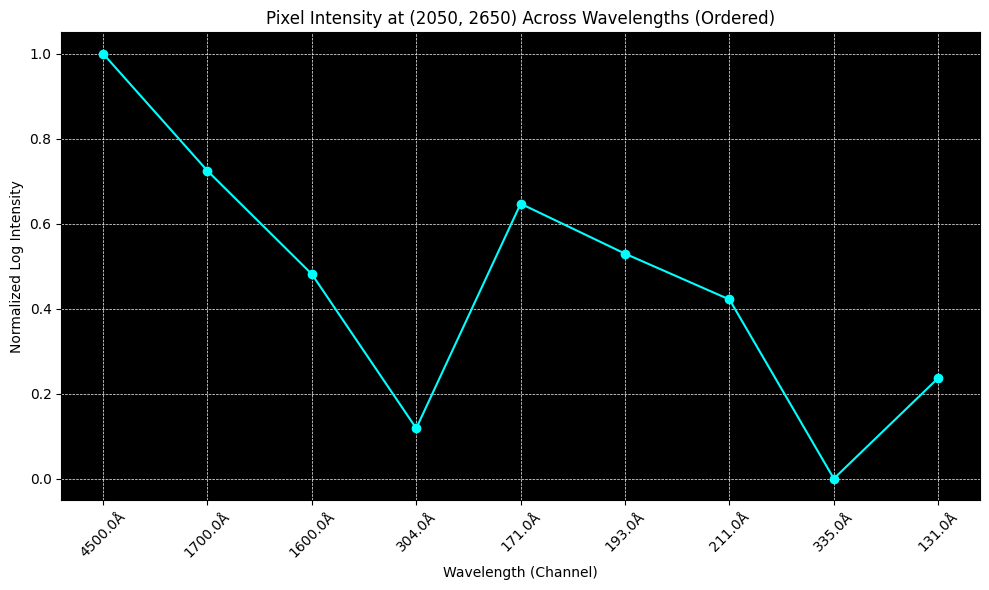

In [12]:
# Coordenadas del píxel que deseas analizar
pixel_x, pixel_y = 2050, 2650  # Cambia esto según las coordenadas que desees

# Orden de los canales desde la superficie solar hacia afuera
channel_order = [
    "4500.0Å", "1700.0Å", "1600.0Å", "304.0Å", 
    "171.0Å", "193.0Å", "211.0Å", "335.0Å", "131.0Å"
]

# Inicializar un diccionario para almacenar los valores del píxel procesados
pixel_values = {}

# Iterar sobre los canales para extraer y procesar el valor del píxel en cada longitud de onda
for channel in channel_order:
    if channel in channel_data_process:
        # Obtener los datos correspondientes al canal
        data = channel_data_process[channel].reshape(4096, 4096)  # Ajustar tamaño si es necesario
        
        # Verificar si las coordenadas están dentro de los límites
        if 0 <= pixel_x < data.shape[0] and 0 <= pixel_y < data.shape[1]:
            pixel_value = data[pixel_x, pixel_y]
            
            # Procesar el valor del píxel (log y normalización)
            if not np.isnan(pixel_value) and pixel_value > 0:
                pixel_values[channel] = np.log10(pixel_value)  # Aplicar logaritmo
            else:
                pixel_values[channel] = np.nan  # Asignar NaN si el valor no es válido
        else:
            pixel_values[channel] = np.nan  # Asignar NaN si las coordenadas están fuera de los límites

# Normalizar los valores procesados
channels_sorted = [ch for ch in channel_order if ch in pixel_values]  # Mantener el orden definido
values_sorted = [pixel_values[ch] for ch in channels_sorted]

# Filtrar valores válidos para la normalización
valid_indices = [i for i, v in enumerate(values_sorted) if not np.isnan(v)]
values_filtered = np.array([values_sorted[i] for i in valid_indices]).reshape(-1, 1)

# Normalizar usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_values = scaler.fit_transform(values_filtered)

# Reconstruir el arreglo con NaN donde los valores eran inválidos
final_values = [np.nan] * len(values_sorted)
for i, idx in enumerate(valid_indices):
    final_values[idx] = normalized_values[i, 0]

# Visualizar los valores del píxel en las diferentes longitudes de onda
plt.figure(figsize=(10, 6), facecolor="white")
plt.plot(channels_sorted, final_values, marker='o', color='cyan')
plt.title(f"Pixel Intensity at ({pixel_x}, {pixel_y}) Across Wavelengths (Ordered)", color="black")
plt.xlabel("Wavelength (Channel)", color="black")
plt.ylabel("Normalized Log Intensity", color="black")
plt.xticks(rotation=45, color="black")
plt.yticks(color="black")
plt.grid(True, linestyle="--", linewidth=0.5, color="white")
plt.gca().set_facecolor("black")  # Fondo negro para los ejes
plt.tight_layout()
plt.show()


/tmp/ipykernel_17195/935946707.py:75: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



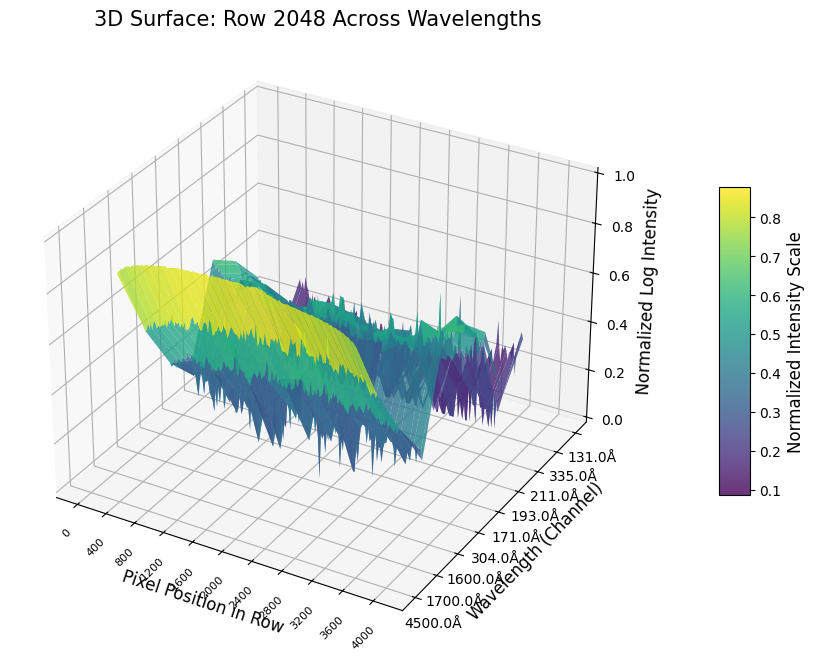

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Coordenadas del píxel y la fila a analizar
pixel_y = 2048  # Fila a analizar
step = 20  # Salto entre píxeles

# Orden de los canales desde la superficie solar hacia afuera
channel_order = [
    "4500.0Å", "1700.0Å", "1600.0Å", "304.0Å", 
    "171.0Å", "193.0Å", "211.0Å", "335.0Å", "131.0Å"
]

# Inicializar una lista para almacenar los datos
surface_data = []

# Iterar sobre los canales para extraer y procesar toda la fila
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalización global
all_data = []

for channel in channel_order:
    if channel in channel_data_process:
        # Obtener los datos correspondientes al canal
        data = channel_data_process[channel].reshape(4096, 4096)
        row_data = data[pixel_y, ::step]
        valid_mask = (~np.isnan(row_data)) & (row_data > 0)
        log_row_data = np.log10(row_data[valid_mask]) if valid_mask.any() else np.array([])
        all_data.extend(log_row_data)  # Acumular datos para normalización global

# Normalización global
scaler.fit(np.array(all_data).reshape(-1, 1))

# Procesar y normalizar cada canal
for channel in channel_order:
    if channel in channel_data_process:
        data = channel_data_process[channel].reshape(4096, 4096)
        row_data = data[pixel_y, ::step]
        valid_mask = (~np.isnan(row_data)) & (row_data > 0)
        log_row_data = np.log10(row_data[valid_mask]) if valid_mask.any() else np.array([])
        normalized_row = np.full(len(row_data), np.nan)
        normalized_row[valid_mask] = scaler.transform(log_row_data.reshape(-1, 1)).flatten()
        surface_data.append(normalized_row)

# Convertir la superficie en un arreglo numpy
surface_data = np.array(surface_data)

# Crear la malla para la gráfica 3D
x = np.arange(0, surface_data.shape[1]) * step  # Píxeles en X
y = np.arange(len(channel_order))  # Canales (índice)
X, Y = np.meshgrid(x, y)

# Crear la gráfica 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(X, Y, surface_data, cmap='viridis', edgecolor='none', alpha=0.8)  # type: ignore


# Ajustar etiquetas y escalas
ax.set_xticks(x[::step])
ax.set_xticklabels(x[::step], rotation=45, fontsize=8)
ax.set_yticks(np.arange(len(channel_order)))
ax.set_yticklabels(channel_order, fontsize=10)
ax.set_xlabel("Pixel Position in Row", fontsize=12)
ax.set_ylabel("Wavelength (Channel)", fontsize=12)
ax.set_zlabel("Normalized Log Intensity", fontsize=12)
ax.set_title(f"3D Surface: Row {pixel_y} Across Wavelengths", fontsize=15)

# Añadir barra de color
colorbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
colorbar.set_label("Normalized Intensity Scale", fontsize=12)

plt.tight_layout()
plt.show()


In [36]:
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.io as pio

# Configurar el renderizador para Visual Studio Code
pio.renderers.default = 'browser'

# Coordenadas del píxel y la fila a analizar
pixel_y = 2650  # Fila a analizar
step = 40  # Salto entre píxeles

# Orden de los canales desde la superficie solar hacia afuera
channel_order = [
    "4500.0Å", "1700.0Å", "1600.0Å", "304.0Å",
    "171.0Å", "193.0Å", "211.0Å", "335.0Å", "131.0Å"
]

# Inicializar una lista para almacenar los datos
surface_data = []

# Iterar sobre los canales para extraer y procesar toda la fila
for channel in channel_order:
    if channel in channel_data_process:
        # Obtener los datos correspondientes al canal
        data = channel_data_process[channel].reshape(4096, 4096)

        if 0 <= pixel_y < data.shape[1]:
            row_data = data[pixel_y, ::step]
            valid_mask = (~np.isnan(row_data)) & (row_data > 0)
            log_row_data = np.log10(row_data[valid_mask]) if valid_mask.any() else np.array([])

            if log_row_data.size > 0:
                scaler = MinMaxScaler(feature_range=(0, 1))
                normalized_row = scaler.fit_transform(log_row_data.reshape(-1, 1)).flatten()
                surface_data.append(normalized_row)
            else:
                surface_data.append(np.full(len(row_data), np.nan))
        else:
            surface_data.append(np.full(len(data[pixel_y, ::step]), np.nan))

# Convertir la superficie en un arreglo numpy
max_length = max(len(row) for row in surface_data)
surface_data = np.array([np.pad(row, (0, max_length - len(row)), constant_values=np.nan) for row in surface_data])

# Crear la malla para la gráfica 3D
x = np.arange(0, surface_data.shape[1]) * step
y = np.arange(len(channel_order))
X, Y = np.meshgrid(x, y)

# Crear la gráfica interactiva 3D
fig = go.Figure(data=[
    go.Surface(
        z=surface_data,
        x=X,
        y=Y,
        colorscale="Viridis",
        colorbar=dict(
            title="Normalized Intensity",
            tickvals=np.linspace(0, 1, 5),  # Rango de valores para normalización
            ticktext=["Low", "Medium-Low", "Medium", "Medium-High", "High"]
        )
    )
])

# Configurar el diseño de la gráfica
fig.update_layout(
    title=f"3D Surface: Row {pixel_y} Across Wavelengths",
    scene=dict(
        xaxis_title="Pixel Position in Row",
        yaxis_title="Wavelength (Channel)",
        zaxis_title="Normalized Log Intensity",
        xaxis=dict(showgrid=True),
        yaxis=dict(
            tickvals=np.arange(len(channel_order)),
            ticktext=channel_order,
            showgrid=True
        ),
        zaxis=dict(showgrid=True)
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Mostrar la gráfica en el navegador
fig.show()


KeyboardInterrupt: 